## グラフ分割問題とグラフカラーリング問題  
あるグラフ$G=(E,V)$が与えられたときに、そのグラフを2つのグループに分割する問題であるグラフ分割問題と、グラフを複数のグラフに分割するグラフカラーリング問題についてのチュートリアルを説明します。

### グラフ分割問題
頂点と辺からなるグラフを二つのグループの頂点の数がなるべく同じになるように分け、異なるグループ同士の頂点を結ぶ辺の数を最小にする。

### イジング式
グラフを2つに分割するために、最適化したい変数は、+1と-1にするとコスト関数がシンプルになります。  
今回の問題では、グラフの頂点に+1と-1の変数を割り当てて、その和が0に近づくときに、よりよく2分割できたといえるので、  
この和を、コスト$H_A$とします。  
  
  
次に、問題では異なるグループ同士の頂点を結ぶ点の個数も最小化したいので、このコストを$H_B$としています。


コスト$H_A$はグラフの頂点の個数$N$だけある、+1と-1をとる変数$z_i$を用意して、その和をとります。

$$
H_A = (\sum^N_{i=1} z_i)^2
$$


コスト$H_B$はグラフの頂点同士$i,j$が接続されているときに$\frac{1 - z_i z_j}{2}$の和を取ります。
$$
H_B = \sum_{i,j \in E} \frac{1 - z_i z_j}{2}
$$

$\frac{1 - z_i z_j}{2}$を見てみましょう。  
グラフの頂点$i,j$が接続されているときに、$i,j$は異なるグループだとしましょう。  
これは$z_i=+1,z_j=-1$とかけるので、  
$\frac{1 - z_i z_j}{2}=1$となります。  
これがもし、同じグループだとしたら、これは$z_i=-1,z_j=-1$とかけるので、  
$\frac{1 - z_i z_j}{2}=0$となります。    
つまり、このコスト$H_B$は異なるグループ同士が辺で結ばれているときに+1となるコスト関数となっており、  
その和をとることで、異なるグループ同士の頂点を結ぶ辺の数を最小にしています。  

### イジング式からQUBO式に変更する

TYTAN SDKは、最適化変数として、0と１のQUBO変数を採用しています。  
+1と-1の変数を0と１に変換するためには、
$$
q_i = \frac{1-z_i}2
$$

$$
z_i = 1-2q_i
$$

の変数変換を行います。
これにより、先ほど説明した$H_A$と$H_B$のコストは下記に変更されます。

$$
H_A = (\sum^N_{i=1} z_i)^2  \\
=(\sum^N_{i=1} 1-2q_i)^2
$$

$$
H_B = \sum_{i,j \in E} \frac{1 - z_i z_j}{2} \\
=\sum_{i,j \in E} \frac{1 - (1-2q_i)(1-2q_j)}{2} \\
=\sum_{i,j \in E} (q_i q_j +q_i +q_j)
$$

### 練習問題
4点からなる下記グラフでグラフ分割問題を解きます。

In [ ]:
# TYTAN SDKのインストール
!pip install -q git+https://github.com/tytansdk/tytan.git

In [ ]:
# グラフ表示用変数のインストール
!pip install --quiet networkx matplotlib

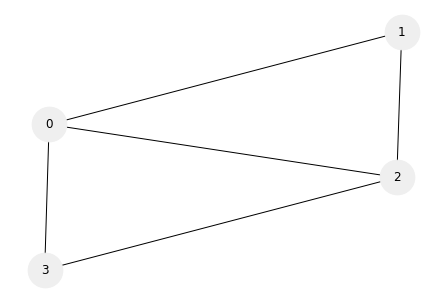

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

N = 4

G = nx.Graph()
G.add_nodes_from(nx.path_graph(N))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2),(2,3)])
nx.draw(G, **options)

グラフの頂点と辺の接続を隣接行列として書き出して、TYTAN SDKに渡します。

In [12]:
import numpy as np

#隣接行列
A = np.triu(nx.to_numpy_array(G))
print(A)

[[0. 1. 1. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


コスト関数を作成します。

In [15]:
#式A
HA = sum([(1-q[i]) for i in range(N)])

#式B
HB = 0.0
for i in range(n):
    for j in range(i+1,n):
        if(A[i,j] == 1):
            HB += (q[i]*q[j]+q[i]+q[j])

#式をつなげます。調整変数を100にしています。
M = 100
H = M*HA**2 + HB

# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)
print(result)

[[{'q_{0}': 1.0, 'q_{10}': 1.0, 'q_{11}': 1.0, 'q_{1}': 1.0, 'q_{2}': 1.0, 'q_{3}': 1.0, 'q_{4}': 1.0, 'q_{5}': 1.0, 'q_{6}': 1.0, 'q_{7}': 1.0, 'q_{8}': 1.0, 'q_{9}': 1.0}, -14388.0, 100]]


4つの頂点が2つのグループに分かれました。異なるグループの間を結ぶ辺の数は最小で3となっています。答えが1010の場合にはコストが上がっており、辺の数は4となるので、最適ではなくなることから確認できます。以上です。

## グラフカラーリング
グラフ分割問題を拡張して、あるn頂点と辺からなるグラフにおいて、  
グラフをm個の種類に分割する問題を見ていきます。  
この問題は、グラフをm個に分割するときにグラフの頂点をmに色分けすると考えることもできるために、  
グラフカラーリング問題とも呼ばれています。

### QUBO式の作成
一つの頂点につきm色を割り当てる制約条件と、隣接する色同士が選ばれないようにペナルティを課す条件を結合します。  
最適化する変数は、グラフの頂点$v$を色$m$で塗分けるときに、$q_{v,m}=1$となり、そうでない場合は0をとる変数です。  
必要な量子ビット数はm色はn頂点で$m*n$となります。  

一つの頂点に対して、色がただ1つ選ばれる制約式$H_A$
$$
H_A = \sum_{v} (1 - \sum_{i=1}^{m}q_{v,i})^2
$$

異なる色同士の頂点を結ぶ辺の数を最小にするコスト関数$H_B$
$$
H_B = \sum_{(uv) \in E}^{n} \sum_{i=1}^{m} q_{u,i}*q_{v,i}
$$

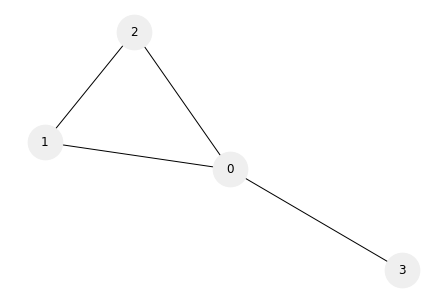

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 4 #頂点数
m = 3 #塗分ける色の数

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2)])
nx.draw(G, **options)

In [17]:
from tytan import *
import sympy as sym

#今回は12量子ビット
N = n*m
q = sym.symbols("q_{0:12}")

#隣接行列
A = np.triu(nx.to_numpy_array(G))

#色の通し番号を格納
b = np.zeros((n,m))

#後で利用するノードの色を表示するための辞書
my_dict = {}

#色を格納
num = 0
for v in range(n):
    for i in range(m):
        b[v][i] = num
        my_dict[num] = [str(v),i]
        num += 1

#色を選択するQUBO
h_1= 0.0
const_h = 0.0
for v in range (n):
    for i in range(m):
        const_h += q[int(b[v,i])]
        
    h_1 += (1 - const_h)**2
    const_h = 0.0

#隣接するノードで同じ色が選択されないQUBO
h_2 = 0.0    
for u in range(n):
    for v in range(n):
        for i in range(m):
            if(A[u,v]==1):
                h_2 += q[int(b[u,i])]*q[int(b[v,i])]

#QUBOを統合
H = h_1 + h_2

In [18]:
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)
#print(result)

print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 0.0, 'q_{10}': 0.0, 'q_{11}': 0.0, 'q_{1}': 0.0, 'q_{2}': 1.0, 'q_{3}': 0.0, 'q_{4}': 1.0, 'q_{5}': 0.0, 'q_{6}': 1.0, 'q_{7}': 0.0, 'q_{8}': 0.0, 'q_{9}': 1.0}
Cost = 0


In [19]:
values_list = [0,0,1,0,1,0,1,0,0,1,0,0]

for i in range(N):
    if(values_list[i]==1):
        print(my_dict[i])

['0', 2]
['1', 1]
['2', 0]
['3', 0]
